In [30]:
import jax.numpy as jnp
from marl_blockchain.rl.BlockchainGraph import *
import jax.tree_util as tree

In [31]:
n = 4
node_features_size = 1

# Create a dummy distances matrix for the example with n=4
distances = jnp.arange(n ** 2).reshape(n, n)
# Set the diagonal to 0
distances = jnp.where(jnp.eye(n), 0, distances) 
distances

Array([[ 0,  1,  2,  3],
       [ 4,  0,  6,  7],
       [ 8,  9,  0, 11],
       [12, 13, 14,  0]], dtype=int32)

In [32]:
# Create a dummy node features matrix for the example with n=4
graph = create_blockchain_graph(distances, node_features_size)

In [33]:
# Create a distribution over the nodes
node_distribution = jnp.array([0.1, 0.2, 0.3, 0.4])

# Set as attributes of the graph
graph = graph._replace(nodes=node_distribution)

In [34]:
def apply_simplified_gcn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # Unpack GraphsTuple
  nodes, _, receivers, senders, _, _, _ = graph

  # 1. Update node features
  # For simplicity, we will first use an identify function here, and replace it
  # with a trainable MLP block later.
  update_node_fn = lambda nodes: nodes
  nodes = update_node_fn(nodes)

  # 2. Aggregate node features over nodes in neighborhood
  # Equivalent to jnp.sum(n_node), but jittable
  total_num_nodes = tree.tree_leaves(nodes)[0].shape[0]
  aggregate_nodes_fn = jax.ops.segment_sum

  # Compute new node features by aggregating messages from neighboring nodes
  nodes = tree.tree_map(lambda x: aggregate_nodes_fn(x[senders], receivers,
                                        total_num_nodes), nodes)
  out_graph = graph._replace(nodes=nodes)
  return out_graph

In [35]:
# Apply the simplified GCN function
gcn_graph = apply_simplified_gcn(graph)

In [36]:
gcn_graph.nodes

Array([1., 1., 1., 1.], dtype=float32)

In [37]:
graph

GraphsTuple(nodes=Array([0.1, 0.2, 0.3, 0.4], dtype=float32), edges=Array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 0],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [ 0],
       [11],
       [12],
       [13],
       [14],
       [ 0]], dtype=int32), receivers=Array([0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3], dtype=int32), senders=Array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], dtype=int32), globals=Array([[0.]], dtype=float32), n_node=Array([4], dtype=int32), n_edge=Array([16], dtype=int32))

In [38]:
# Transform the node_distances matrix into a symmetric matrix
def make_symmetric(matrix: jnp.ndarray) -> jnp.ndarray:
  return matrix + matrix.T - jnp.diag(jnp.diag(matrix))

# Create a dummy distances matrix for the example with n=4
distances = jnp.arange(n ** 2).reshape(n, n)
# Set the diagonal to 0
distances = jnp.where(jnp.eye(n), 0, distances)
# Make the matrix symmetric

distances = make_symmetric(distances)
distances

Array([[ 0,  5, 10, 15],
       [ 5,  0, 15, 20],
       [10, 15,  0, 25],
       [15, 20, 25,  0]], dtype=int32)

In [39]:
from marl_blockchain.rl.env import *

env = BlockchainEnv_intermediary(node_distance_matrix=distances, node_features=["node_id","inner_chosen","distrib_chosen"], voting_nodes=3)

In [40]:
state = env.reset()

In [41]:
action = env.sample_legal_action(state)

In [42]:
action

Array([0., 1., 0., 0.], dtype=float32)

In [43]:
new_state, reward, done, info = env.step(state, action, jnp.array([0.1, 0.9]))

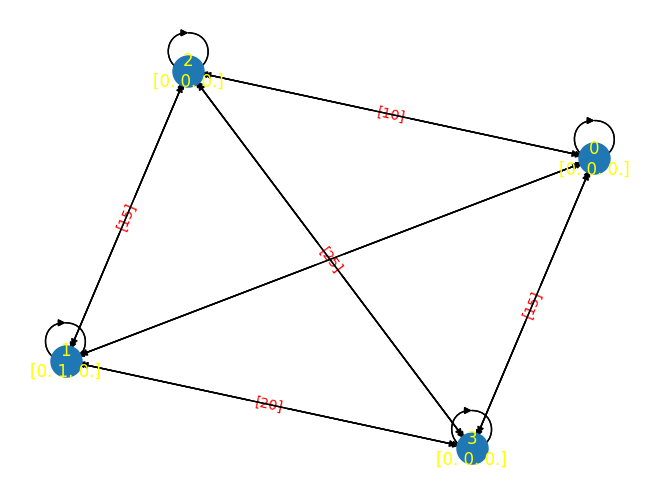

In [44]:
draw_jraph_graph_structure(new_state.blockchain)

In [86]:
import jraph as jr
import flax
import jax
import flax.linen as nn
import distrax

In [87]:
def make_embed_fn(latent_size):
  def embed(inputs):
    return nn.Dense(latent_size)(inputs)
  return embed

In [88]:
def _attention_logit_fn(sender_attr: jnp.ndarray,
                        receiver_attr: jnp.ndarray,
                        edges: jnp.ndarray) -> jnp.ndarray:
  x = jnp.concatenate((sender_attr, receiver_attr, edges), axis=1)
  return nn.Dense(1)(x)

In [89]:
class PolicyNET_GAT(nn.Module):
    """
    Graph Attention Network (GAT) module using flax and jraph
    """
    
    gat1_output_dim: int
    gat2_output_dim: int
    gat2_nodes_output_dim: int
    action_dim: int
    
    @nn.compact
    def __call__(self, x):
        gcn1 = jr.GraphConvolution(
            update_node_fn=lambda n: jax.nn.relu(make_embed_fn(self.gat1_output_dim)(n)),
            add_self_edges=True,
        )
        
        gcn2 = jr.GraphConvolution(
            update_node_fn=lambda n: jax.nn.relu(make_embed_fn(self.gat2_output_dim)(n)),
            add_self_edges=True,
        )
        
        gat1 = jr.GAT(
            attention_query_fn=lambda n: make_embed_fn(self.gat1_output_dim)(n),
            attention_logit_fn=_attention_logit_fn,
            node_update_fn=None
        )
        
        gat2 = jr.GAT(
            attention_query_fn=lambda n: make_embed_fn(self.gat2_output_dim)(n),
            attention_logit_fn=_attention_logit_fn,
            node_update_fn=lambda n: make_embed_fn(self.gat2_nodes_output_dim)(n)
        )
        
        x._replace(globals=jnp.zeros((1, self.action_dim)))
        
        @jr.concatenated_args
        def concat_fn(x):
            return jax.nn.relu(make_embed_fn(self.gat1_output_dim)(x))
        
        @jr.concatenated_args
        def concat_fn_final(x):
            return jax.nn.relu(make_embed_fn(self.action_dim)(x))
        
        gnn = jr.GraphNetwork(
            update_edge_fn=concat_fn,
            update_node_fn=concat_fn,
            update_global_fn=concat_fn_final
        )
        x = gcn1(x)
        x = gcn2(x)
        x = gat1(x)
        x = gat2(x)
        x = gnn(x)
        
        pi = distrax.Categorical(logits=x.globals)
        return pi

In [90]:
# Get a graph from the environment
graph = new_state.blockchain

In [91]:
# Create a GAT model
gat = PolicyNET_GAT(gat1_output_dim=32, gat2_output_dim=16, gat2_nodes_output_dim=8, action_dim=3)
gat

GAT(
    # attributes
    gat1_output_dim = 32
    gat2_output_dim = 16
    gat2_nodes_output_dim = 8
    action_dim = 3
)

In [92]:
params = gat.init(jax.random.PRNGKey(0), graph)

In [93]:
res = gat.apply(params, graph)

In [94]:
res

In [95]:
# Random key for sampling (required by JAX)
key = jax.random.PRNGKey(0)

# Sample a category index
sample = res.sample(seed=key)
print(f"Sampled category index: {sample}")


Sampled category index: [0]


In [96]:
import jax
import jax.numpy as jnp
from jax import lax

# Original function for comparison
def original_compute_gae(rewards, values, dones, last_value, gamma=0.99, lambda_=0.95):
    advantages = []
    advantage = 0.0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * last_value * (1.0 - dones[i]) - values[i]
        advantage = delta + gamma * lambda_ * advantage * (1.0 - dones[i])
        advantages.insert(0, advantage)
        last_value = values[i]
    return jnp.array(advantages)

# Optimized function using jax.lax.scan
@jax.jit
def optimized_compute_gae(rewards, values, dones, last_value, gamma=0.99, lambda_=0.95):
    values = jnp.append(values, last_value)
    
    def scan_fn(carry, idx):
        advantage, next_value = carry
        reward = rewards[idx]
        value = values[idx]
        done = dones[idx]
        
        delta = reward + gamma * next_value * (1.0 - done) - value
        advantage = delta + gamma * lambda_ * advantage * (1.0 - done)
        
        return (advantage, value), advantage
    
    init = (0.0, last_value)
    
    _, advantages = lax.scan(scan_fn, init, jnp.arange(len(rewards) - 1, -1, -1))
    return jnp.flip(advantages)

# Test data
rewards = jnp.array([1.0, 1.0, 1.0, 1.0])
values = jnp.array([0.5, 0.6, 0.7, 0.8])
dones = jnp.array([0, 0, 1, 0])
last_value = 0.9
gamma = 0.99
lambda_ = 0.95

# Get results from both functions
original_result = original_compute_gae(rewards, values, dones, last_value, gamma, lambda_)
optimized_result = optimized_compute_gae(rewards, values, dones, last_value, gamma, lambda_)

# Compare the results
original_result, optimized_result, jnp.allclose(original_result, optimized_result)


(Array([2.3873286, 1.3751501, 0.3      , 1.0910001], dtype=float32),
 Array([2.3873286, 1.3751501, 0.3      , 1.0910001], dtype=float32),
 Array(True, dtype=bool))